In [40]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [41]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [42]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [43]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [44]:
tf.keras.backend.clear_session()

In [45]:
subject = 'Tocantins - Consumo de Cimento (t)'
start_index = 0
split_index = 179
window_size = 36
train_split = split_index + 1 - 12

In [46]:
data = pd.read_csv('2003_mo_model_input_TO.csv')
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data =data.drop([' NFSP - Fluxo Mensal (Milhões de reais)'], axis=1)
data

,Unnamed: 0,IPCA - Variação mensal durante o Plano Real (%),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Tocantins - Desemprego,Tocantins - PIB - Estadual,Tocantins - PIB - Construção Civil,Tocantins - PIB - Per Capita,Tocantins - PIB - Preços de Mercado,Tocantins - Produção de Cimento (t),Tocantins - IDH,Tocantins - Consumo de Cimento (t)
0,2003-1,0.724032,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,8.243830,1.593908e+07,1.457380e+06,10.276585,2.572692e+07,12.733000,0.700107,17.555
1,2003-2,0.690297,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,8.237931,1.596108e+07,1.459029e+06,10.281590,2.576177e+07,12.733000,0.700487,14.976
2,2003-3,0.669681,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,8.232033,1.598308e+07,1.460678e+06,10.286595,2.579662e+07,12.733000,0.700866,13.334
3,2003-4,0.660494,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,8.226135,1.600508e+07,1.462328e+06,10.291600,2.583147e+07,12.733000,0.701246,15.173
4,2003-5,0.648337,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,8.220236,1.602709e+07,1.463977e+06,10.296605,2.586632e+07,12.733000,0.701626,18.728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67.097178,NaN,54.154
236,2022-9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67.077411,NaN,55.664
237,2022-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.563807,NaN,52.320
238,2022-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.682099,NaN,43.036


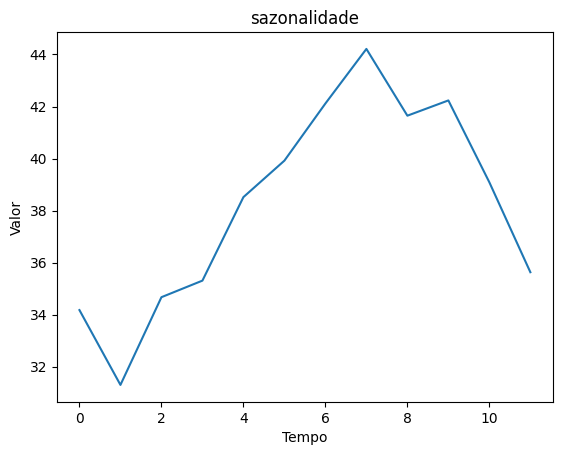

,sazonalidade
sazonalidade,
0,34.175036
1,31.298071
2,34.670393
3,35.307286
4,38.517000
5,39.919429
6,42.115786
7,44.213929
8,41.647571


In [47]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [48]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,IPCA - Variação mensal durante o Plano Real (%),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Tocantins - Desemprego,Tocantins - PIB - Estadual,Tocantins - PIB - Construção Civil,Tocantins - PIB - Per Capita,Tocantins - PIB - Preços de Mercado,Tocantins - Produção de Cimento (t),Tocantins - IDH,sazonalidade,Tocantins - Consumo de Cimento (t)
0,2003-1,0.724032,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,8.243830,1.593908e+07,1.457380e+06,10.276585,2.572692e+07,12.733000,0.700107,34.175036,17.555
1,2003-2,0.690297,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,8.237931,1.596108e+07,1.459029e+06,10.281590,2.576177e+07,12.733000,0.700487,31.298071,14.976
2,2003-3,0.669681,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,8.232033,1.598308e+07,1.460678e+06,10.286595,2.579662e+07,12.733000,0.700866,34.670393,13.334
3,2003-4,0.660494,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,8.226135,1.600508e+07,1.462328e+06,10.291600,2.583147e+07,12.733000,0.701246,35.307286,15.173
4,2003-5,0.648337,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,8.220236,1.602709e+07,1.463977e+06,10.296605,2.586632e+07,12.733000,0.701626,38.517000,18.728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67.097178,NaN,44.213929,54.154
236,2022-9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67.077411,NaN,41.647571,55.664
237,2022-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.563807,NaN,42.233857,52.320
238,2022-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.682099,NaN,39.086143,43.036


In [49]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      29.644
1      25.375
2      25.608
3      30.043
4      28.702
        ...  
235       NaN
236       NaN
237       NaN
238       NaN
239       NaN
Name: Tocantins - Consumo de Cimento (t), Length: 240, dtype: float64

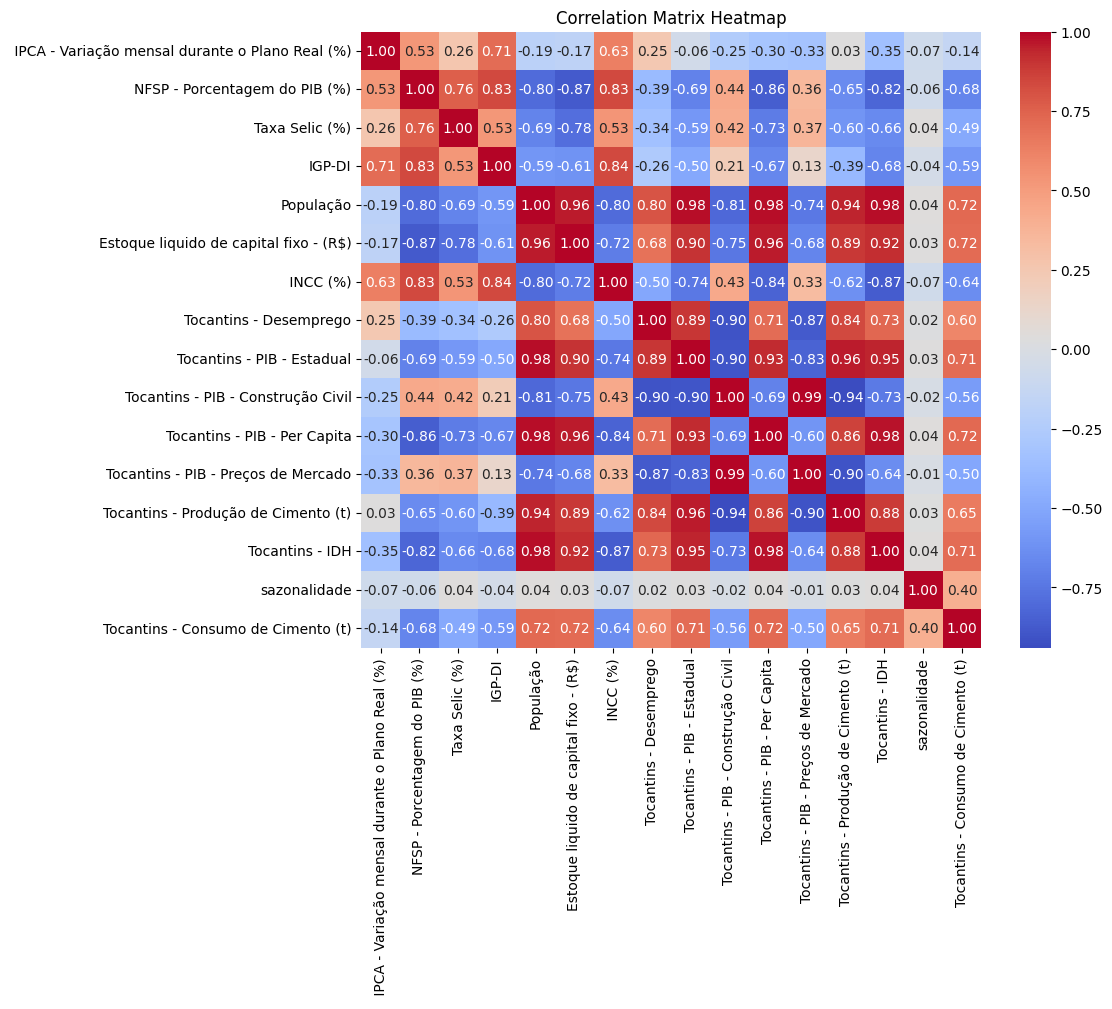

In [50]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [51]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [52]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,IPCA - Variação mensal durante o Plano Real (%),5.428103e+02
1,NFSP - Porcentagem do PIB (%),1.822571e+02
2,Taxa Selic (%),4.805706e+01
3,IGP-DI,1.839014e+02
4,População,5.535734e+06
5,Estoque liquido de capital fixo - (R$),7.766023e+05
6,INCC (%),9.913382e+02
7,Tocantins - Desemprego,4.161217e+03
8,Tocantins - PIB - Estadual,6.048875e+05
9,Tocantins - PIB - Construção Civil,1.174598e+06


In [53]:
data = remove_high_vif_columns(safe_data, 10000000)
data

Num columns removed: 0


,IPCA - Variação mensal durante o Plano Real (%),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Tocantins - Desemprego,Tocantins - PIB - Estadual,Tocantins - PIB - Construção Civil,Tocantins - PIB - Per Capita,Tocantins - PIB - Preços de Mercado,Tocantins - Produção de Cimento (t),Tocantins - IDH,sazonalidade
0,0.724032,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,8.243830,1.593908e+07,1.457380e+06,10.276585,2.572692e+07,12.733000,0.700107,34.175036
1,0.690297,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,8.237931,1.596108e+07,1.459029e+06,10.281590,2.576177e+07,12.733000,0.700487,31.298071
2,0.669681,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,8.232033,1.598308e+07,1.460678e+06,10.286595,2.579662e+07,12.733000,0.700866,34.670393
3,0.660494,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,8.226135,1.600508e+07,1.462328e+06,10.291600,2.583147e+07,12.733000,0.701246,35.307286
4,0.648337,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,8.220236,1.602709e+07,1.463977e+06,10.296605,2.586632e+07,12.733000,0.701626,38.517000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.366904,2.206994,0.545067,0.471521,1.987710e+08,7.783063e+06,0.378150,9.816747,1.997438e+07,1.269070e+06,10.765772,2.384798e+07,48.652287,0.735665,44.213929
176,0.358935,2.215328,0.782910,0.476827,1.988450e+08,7.780841e+06,0.377666,9.805643,1.997330e+07,1.270047e+06,10.765962,2.386671e+07,48.949624,0.735634,41.647571
177,0.354313,2.232466,0.909682,0.475427,1.989190e+08,7.778619e+06,0.377838,9.794539,1.997222e+07,1.271024e+06,10.766153,2.388545e+07,49.201167,0.735603,42.233857
178,0.352728,2.263185,1.050614,0.491301,1.989930e+08,7.776397e+06,0.370057,9.783436,1.997114e+07,1.272002e+06,10.766343,2.390419e+07,49.047529,0.735571,39.086143


In [54]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
input_data

,NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Tocantins - Desemprego,Tocantins - PIB - Estadual,Tocantins - PIB - Construção Civil,Tocantins - PIB - Per Capita,Tocantins - PIB - Preços de Mercado,Tocantins - Produção de Cimento (t),Tocantins - IDH
0,4.268118,2.039314,3.921218,-2.016914,-2.299937,3.214079,-0.679567,-1.595053,0.574852,-2.366953,0.280977,-1.191217,-2.203325
1,4.096014,1.195209,3.582946,-1.988421,-2.263992,3.051841,-0.685602,-1.578873,0.587700,-2.330241,0.299761,-1.191217,-2.163461
2,3.903698,2.960381,3.422548,-1.959928,-2.228047,2.944772,-0.691636,-1.562692,0.600548,-2.293528,0.318545,-1.191217,-2.123598
3,3.693727,1.040752,3.167136,-1.931435,-2.192102,2.842174,-0.697671,-1.546512,0.613396,-2.256815,0.337330,-1.191217,-2.083734
4,3.454992,2.351150,2.986591,-1.902941,-2.156157,3.059587,-0.703705,-1.530331,0.626244,-2.220103,0.356114,-1.191217,-2.043871
...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,-0.584804,-1.503380,-0.514871,1.368581,0.605679,-1.872446,0.929673,1.372537,-0.892166,1.221295,-0.731721,1.298560,1.529009
176,-0.580461,-0.733634,-0.473208,1.380202,0.591420,-1.876611,0.918313,1.371742,-0.884554,1.222691,-0.721622,1.319170,1.525736
177,-0.571531,-0.323353,-0.484199,1.391823,0.577161,-1.875135,0.906953,1.370946,-0.876943,1.224088,-0.711524,1.336606,1.522462
178,-0.555524,0.132757,-0.359568,1.403443,0.562902,-1.942040,0.895593,1.370151,-0.869332,1.225484,-0.701425,1.325956,1.519189


In [55]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Tocantins - Desemprego,Tocantins - PIB - Estadual,Tocantins - PIB - Construção Civil,Tocantins - PIB - Per Capita,Tocantins - PIB - Preços de Mercado,Tocantins - Produção de Cimento (t),Tocantins - IDH
0,4.268118,2.039314,3.921218,-2.016914,-2.299937,3.214079,-0.679567,-1.595053,0.574852,-2.366953,0.280977,-1.191217,-2.203325
1,4.096014,1.195209,3.582946,-1.988421,-2.263992,3.051841,-0.685602,-1.578873,0.587700,-2.330241,0.299761,-1.191217,-2.163461
2,3.903698,2.960381,3.422548,-1.959928,-2.228047,2.944772,-0.691636,-1.562692,0.600548,-2.293528,0.318545,-1.191217,-2.123598
3,3.693727,1.040752,3.167136,-1.931435,-2.192102,2.842174,-0.697671,-1.546512,0.613396,-2.256815,0.337330,-1.191217,-2.083734
4,3.454992,2.351150,2.986591,-1.902941,-2.156157,3.059587,-0.703705,-1.530331,0.626244,-2.220103,0.356114,-1.191217,-2.043871
...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,-0.676734,0.472779,-1.087000,1.228701,0.759879,-1.491033,1.221600,1.350541,-0.995336,1.156155,-0.856074,1.034200,1.545060
164,-0.668750,0.302784,-0.904679,1.240408,0.749001,-1.525186,1.179119,1.356054,-0.985358,1.167228,-0.845342,1.071339,1.546433
165,-0.657609,0.339539,-0.900134,1.252114,0.738124,-1.546744,1.136637,1.361567,-0.975380,1.178300,-0.834609,1.119784,1.547806
166,-0.647588,0.472795,-1.136836,1.263821,0.727246,-1.586381,1.094156,1.367080,-0.965402,1.189373,-0.823877,1.157903,1.549179


In [56]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      29.644
1      25.375
2      25.608
3      30.043
4      28.702
        ...  
163    38.793
164    38.281
165    39.711
166    33.695
167    28.206
Name: Tocantins - Consumo de Cimento (t), Length: 168, dtype: float64

In [57]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [58]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(132, 36, 13)

In [59]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Tocantins - Desemprego,Tocantins - PIB - Estadual,Tocantins - PIB - Construção Civil,Tocantins - PIB - Per Capita,Tocantins - PIB - Preços de Mercado,Tocantins - Produção de Cimento (t),Tocantins - IDH
132,-0.366715,-0.530011,0.174628,0.848407,0.965586,-0.066954,1.314607,0.990289,-1.161521,0.758584,-1.181630,1.059475,0.546438
133,-0.350285,-0.532694,0.240832,0.861179,0.962419,-0.130652,1.340875,1.006274,-1.158377,0.774512,-1.171074,1.057240,0.538642
134,-0.335122,-0.186421,0.176857,0.873950,0.959252,-0.079602,1.367142,1.022258,-1.155234,0.790441,-1.160517,1.049012,0.530845
135,-0.321950,-0.719664,-0.005233,0.886722,0.956085,-0.034473,1.393410,1.038243,-1.152090,0.806369,-1.149961,1.040216,0.523049
136,-0.302995,-0.798520,0.097576,0.899493,0.952918,-0.177535,1.419678,1.054228,-1.148946,0.822298,-1.139405,1.030948,0.515252
137,-0.290554,-0.612129,0.431487,0.912265,0.949751,-0.208868,1.445946,1.070213,-1.145802,0.838227,-1.128849,1.021351,0.507456
138,-0.281926,-0.476740,0.482414,0.925036,0.946584,-0.245300,1.472213,1.086198,-1.142658,0.854155,-1.118293,1.011473,0.499659
139,-0.275931,-0.211736,0.657043,0.937808,0.943417,-0.333490,1.498481,1.102183,-1.139514,0.870084,-1.107737,1.001140,0.491863
140,-0.271466,-0.484608,0.678386,0.950580,0.940250,-0.296846,1.524749,1.118168,-1.136370,0.886012,-1.097181,0.990031,0.484066
141,-0.273241,-0.183907,0.727143,0.963351,0.937082,-0.292462,1.551017,1.134152,-1.133226,0.901941,-1.086625,0.978175,0.476270


In [60]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 13)

In [61]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [62]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.LSTM(144, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.07,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [63]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [64]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[3427872074, 1589556740, 4089757156, 1121844752, 1790345148, 3021101706, 956688021, 434682989, 2771899149, 1344469921]


Step: 0 ___________________________________________
val_loss: 73.69598388671875
winner_seed: 3427872074


Step: 1 ___________________________________________
val_loss: 84.4168472290039


Step: 2 ___________________________________________
val_loss: 54.921974182128906
winner_seed: 4089757156


Step: 3 ___________________________________________
val_loss: 115.83744812011719


Step: 4 ___________________________________________
val_loss: 71.97898864746094


Step: 5 ___________________________________________
val_loss: 58.81230545043945


Step: 6 ___________________________________________
val_loss: 61.01122283935547


Step: 7 ___________________________________________
val_loss: 11.172767639160156
winner_seed: 434682989


Step: 8 ___________________________________________
val_loss: 101.2640380859375


Step: 9 ___________________________________________
val_loss: 98.535

In [65]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)

Epoch 1/10000
4/4 [==============================] - 2s 130ms/step - loss: 1465.9669 - val_loss: 29.5851
Epoch 2/10000
4/4 [==============================] - 0s 11ms/step - loss: 56.6418 - val_loss: 144.2405
Epoch 3/10000
4/4 [==============================] - 0s 10ms/step - loss: 42.8221 - val_loss: 106.1061
Epoch 4/10000
4/4 [==============================] - 0s 11ms/step - loss: 42.0692 - val_loss: 244.7592
Epoch 5/10000
4/4 [==============================] - 0s 11ms/step - loss: 42.5861 - val_loss: 103.6737
Epoch 6/10000
4/4 [==============================] - 0s 11ms/step - loss: 38.5357 - val_loss: 187.2999
Epoch 7/10000
4/4 [==============================] - 0s 10ms/step - loss: 42.0957 - val_loss: 135.8176
Epoch 8/10000
4/4 [==============================] - 0s 11ms/step - loss: 40.1729 - val_loss: 106.7390
Epoch 9/10000
4/4 [==============================] - 0s 11ms/step - loss: 36.2813 - val_loss: 128.2724
Epoch 10/10000
4/4 [==============================] - 0s 10ms/step - lo

4/4 [==============================] - 0s 11ms/step - loss: 25.5607 - val_loss: 33.2378
Epoch 81/10000
4/4 [==============================] - 0s 10ms/step - loss: 27.0797 - val_loss: 33.2844
Epoch 82/10000
4/4 [==============================] - 0s 11ms/step - loss: 24.2267 - val_loss: 30.9301
Epoch 83/10000
4/4 [==============================] - 0s 10ms/step - loss: 25.6261 - val_loss: 30.6690
Epoch 84/10000
4/4 [==============================] - 0s 10ms/step - loss: 24.6280 - val_loss: 33.7993
Epoch 85/10000
4/4 [==============================] - 0s 11ms/step - loss: 26.1229 - val_loss: 29.6639
Epoch 86/10000
4/4 [==============================] - 0s 11ms/step - loss: 24.3972 - val_loss: 30.5264
Epoch 87/10000
4/4 [==============================] - 0s 11ms/step - loss: 25.6576 - val_loss: 31.3520
Epoch 88/10000
4/4 [==============================] - 0s 11ms/step - loss: 25.1493 - val_loss: 31.1172
Epoch 89/10000
4/4 [==============================] - 0s 12ms/step - loss: 27.1286 - val

4/4 [==============================] - 0s 11ms/step - loss: 16.3679 - val_loss: 49.3704
Epoch 160/10000
4/4 [==============================] - 0s 11ms/step - loss: 13.3383 - val_loss: 45.3994
Epoch 161/10000
4/4 [==============================] - 0s 11ms/step - loss: 14.3930 - val_loss: 42.5586
Epoch 162/10000
4/4 [==============================] - 0s 11ms/step - loss: 13.0557 - val_loss: 59.3244
Epoch 163/10000
4/4 [==============================] - 0s 11ms/step - loss: 13.9504 - val_loss: 51.2196
Epoch 164/10000
4/4 [==============================] - 0s 11ms/step - loss: 15.1329 - val_loss: 54.2119
Epoch 165/10000
4/4 [==============================] - 0s 10ms/step - loss: 13.2773 - val_loss: 54.7876
Epoch 166/10000
4/4 [==============================] - 0s 11ms/step - loss: 14.5001 - val_loss: 74.5663
Epoch 167/10000
4/4 [==============================] - 0s 10ms/step - loss: 13.4214 - val_loss: 49.5411
Epoch 168/10000
4/4 [==============================] - 0s 10ms/step - loss: 13.0

Epoch 238/10000
4/4 [==============================] - 0s 10ms/step - loss: 10.2402 - val_loss: 110.3155
Epoch 239/10000
4/4 [==============================] - 0s 10ms/step - loss: 10.4410 - val_loss: 96.3475
Epoch 240/10000
4/4 [==============================] - 0s 10ms/step - loss: 11.8392 - val_loss: 102.5082
Epoch 241/10000
4/4 [==============================] - 0s 10ms/step - loss: 10.6823 - val_loss: 104.4057
Epoch 242/10000
4/4 [==============================] - 0s 12ms/step - loss: 9.2880 - val_loss: 84.0124
Epoch 243/10000
4/4 [==============================] - 0s 12ms/step - loss: 10.4783 - val_loss: 97.9595
Epoch 244/10000
4/4 [==============================] - 0s 12ms/step - loss: 11.0522 - val_loss: 108.3783
Epoch 245/10000
4/4 [==============================] - 0s 12ms/step - loss: 10.0706 - val_loss: 103.1953
Epoch 246/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.7986 - val_loss: 95.3602
Epoch 247/10000
4/4 [==============================] - 0s 10m

4/4 [==============================] - 0s 10ms/step - loss: 9.6763 - val_loss: 112.4862
Epoch 317/10000
4/4 [==============================] - 0s 10ms/step - loss: 9.7774 - val_loss: 103.5228
Epoch 318/10000
4/4 [==============================] - 0s 10ms/step - loss: 10.1813 - val_loss: 120.3268
Epoch 319/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.7577 - val_loss: 114.6118
Epoch 320/10000
4/4 [==============================] - 0s 11ms/step - loss: 9.6411 - val_loss: 111.4604
Epoch 321/10000
4/4 [==============================] - 0s 11ms/step - loss: 9.4417 - val_loss: 102.2265
Epoch 322/10000
4/4 [==============================] - 0s 11ms/step - loss: 10.0594 - val_loss: 114.3151
Epoch 323/10000
4/4 [==============================] - 0s 11ms/step - loss: 9.7135 - val_loss: 112.3487
Epoch 324/10000
4/4 [==============================] - 0s 11ms/step - loss: 9.5279 - val_loss: 113.0624
Epoch 325/10000
4/4 [==============================] - 0s 11ms/step - loss: 9.

Epoch 395/10000
4/4 [==============================] - 0s 10ms/step - loss: 9.4183 - val_loss: 130.4065
Epoch 396/10000
4/4 [==============================] - 0s 10ms/step - loss: 10.7091 - val_loss: 123.2859
Epoch 397/10000
4/4 [==============================] - 0s 10ms/step - loss: 9.8234 - val_loss: 118.4920
Epoch 398/10000
4/4 [==============================] - 0s 10ms/step - loss: 9.1177 - val_loss: 129.3469
Epoch 399/10000
4/4 [==============================] - 0s 9ms/step - loss: 9.0389 - val_loss: 112.8491
Epoch 400/10000
4/4 [==============================] - 0s 10ms/step - loss: 11.3396 - val_loss: 100.5818
Epoch 401/10000
4/4 [==============================] - 0s 10ms/step - loss: 10.0805 - val_loss: 102.0471
Epoch 402/10000
4/4 [==============================] - 0s 10ms/step - loss: 11.9216 - val_loss: 103.6119
Epoch 403/10000
4/4 [==============================] - 0s 9ms/step - loss: 10.3928 - val_loss: 115.0569
Epoch 404/10000
4/4 [==============================] - 0s 9ms

Epoch 474/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.8359 - val_loss: 119.1189
Epoch 475/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.8615 - val_loss: 115.8147
Epoch 476/10000
4/4 [==============================] - 0s 10ms/step - loss: 8.3164 - val_loss: 116.6090
Epoch 477/10000
4/4 [==============================] - 0s 11ms/step - loss: 9.1815 - val_loss: 99.3846
Epoch 478/10000
4/4 [==============================] - 0s 11ms/step - loss: 9.0864 - val_loss: 114.9911
Epoch 479/10000
4/4 [==============================] - 0s 11ms/step - loss: 11.2978 - val_loss: 87.4806
Epoch 480/10000
4/4 [==============================] - 0s 11ms/step - loss: 9.4278 - val_loss: 89.3994
Epoch 481/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.2912 - val_loss: 106.0807
Epoch 482/10000
4/4 [==============================] - 0s 11ms/step - loss: 9.1695 - val_loss: 109.9227
Epoch 483/10000
4/4 [==============================] - 0s 10ms/ste

4/4 [==============================] - 0s 11ms/step - loss: 7.7337 - val_loss: 129.1693
Epoch 554/10000
4/4 [==============================] - 0s 11ms/step - loss: 9.4285 - val_loss: 111.1971
Epoch 555/10000
4/4 [==============================] - 0s 8ms/step - loss: 8.2841 - val_loss: 125.0727
Epoch 556/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.7884 - val_loss: 113.8162
Epoch 557/10000
4/4 [==============================] - 0s 9ms/step - loss: 9.2794 - val_loss: 114.1429
Epoch 558/10000
4/4 [==============================] - 0s 8ms/step - loss: 8.0415 - val_loss: 122.3944
Epoch 559/10000
4/4 [==============================] - 0s 10ms/step - loss: 10.6132 - val_loss: 113.8178
Epoch 560/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.3121 - val_loss: 111.2103
Epoch 561/10000
4/4 [==============================] - 0s 10ms/step - loss: 7.5329 - val_loss: 112.7489
Epoch 562/10000
4/4 [==============================] - 0s 10ms/step - loss: 7.9351 -

4/4 [==============================] - 0s 10ms/step - loss: 7.5842 - val_loss: 115.3689
Epoch 633/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.3283 - val_loss: 111.7994
Epoch 634/10000
4/4 [==============================] - 0s 12ms/step - loss: 8.5049 - val_loss: 124.1200
Epoch 635/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.0117 - val_loss: 116.2950
Epoch 636/10000
4/4 [==============================] - 0s 10ms/step - loss: 7.7950 - val_loss: 119.6051
Epoch 637/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.8349 - val_loss: 113.3136
Epoch 638/10000
4/4 [==============================] - 0s 12ms/step - loss: 7.1759 - val_loss: 105.0282
Epoch 639/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.1946 - val_loss: 120.3548
Epoch 640/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.0555 - val_loss: 121.0538
Epoch 641/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.50

4/4 [==============================] - 0s 10ms/step - loss: 12.8506 - val_loss: 34.9601
Epoch 712/10000
4/4 [==============================] - 0s 10ms/step - loss: 9.0035 - val_loss: 50.4295
Epoch 713/10000
4/4 [==============================] - 0s 10ms/step - loss: 10.0829 - val_loss: 52.7830
Epoch 714/10000
4/4 [==============================] - 0s 10ms/step - loss: 10.2497 - val_loss: 50.1056
Epoch 715/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.9213 - val_loss: 51.0995
Epoch 716/10000
4/4 [==============================] - 0s 10ms/step - loss: 8.1686 - val_loss: 39.4181
Epoch 717/10000
4/4 [==============================] - 0s 11ms/step - loss: 9.6419 - val_loss: 31.6021
Epoch 718/10000
4/4 [==============================] - 0s 11ms/step - loss: 9.5768 - val_loss: 54.9871
Epoch 719/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.5668 - val_loss: 46.5026
Epoch 720/10000
4/4 [==============================] - 0s 10ms/step - loss: 11.1185 - 

4/4 [==============================] - 0s 10ms/step - loss: 8.7654 - val_loss: 76.4212
Epoch 791/10000
4/4 [==============================] - 0s 10ms/step - loss: 7.8605 - val_loss: 77.7307
Epoch 792/10000
4/4 [==============================] - 0s 10ms/step - loss: 9.0318 - val_loss: 50.8428
Epoch 793/10000
4/4 [==============================] - 0s 10ms/step - loss: 7.9097 - val_loss: 76.8575
Epoch 794/10000
4/4 [==============================] - 0s 10ms/step - loss: 8.7978 - val_loss: 75.2449
Epoch 795/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.8070 - val_loss: 68.8180
Epoch 796/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.8226 - val_loss: 75.2403
Epoch 797/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.6599 - val_loss: 82.2598
Epoch 798/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.2951 - val_loss: 78.3655
Epoch 799/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.3882 - val_

4/4 [==============================] - 0s 10ms/step - loss: 8.1020 - val_loss: 99.9795
Epoch 870/10000
4/4 [==============================] - 0s 10ms/step - loss: 7.7836 - val_loss: 97.8513
Epoch 871/10000
4/4 [==============================] - 0s 10ms/step - loss: 8.3592 - val_loss: 104.1545
Epoch 872/10000
4/4 [==============================] - 0s 10ms/step - loss: 8.2583 - val_loss: 79.7023
Epoch 873/10000
4/4 [==============================] - 0s 9ms/step - loss: 7.8515 - val_loss: 89.7218
Epoch 874/10000
4/4 [==============================] - 0s 10ms/step - loss: 9.3905 - val_loss: 75.2295
Epoch 875/10000
4/4 [==============================] - 0s 10ms/step - loss: 8.1616 - val_loss: 95.4776
Epoch 876/10000
4/4 [==============================] - 0s 10ms/step - loss: 7.2140 - val_loss: 78.3568
Epoch 877/10000
4/4 [==============================] - 0s 10ms/step - loss: 7.1680 - val_loss: 102.2817
Epoch 878/10000
4/4 [==============================] - 0s 10ms/step - loss: 8.1422 - val

4/4 [==============================] - 0s 10ms/step - loss: 7.2292 - val_loss: 79.0266
Epoch 949/10000
4/4 [==============================] - 0s 9ms/step - loss: 7.8216 - val_loss: 54.8100
Epoch 950/10000
4/4 [==============================] - 0s 10ms/step - loss: 7.3600 - val_loss: 70.4011
Epoch 951/10000
4/4 [==============================] - 0s 10ms/step - loss: 7.2165 - val_loss: 87.8516
Epoch 952/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.5926 - val_loss: 76.6085
Epoch 953/10000
4/4 [==============================] - 0s 10ms/step - loss: 7.2597 - val_loss: 71.3723
Epoch 954/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.9053 - val_loss: 74.1423
Epoch 955/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.6071 - val_loss: 73.0936
Epoch 956/10000
4/4 [==============================] - 0s 10ms/step - loss: 8.1446 - val_loss: 69.4394
Epoch 957/10000
4/4 [==============================] - 0s 10ms/step - loss: 8.6000 - val_l

4/4 [==============================] - 0s 10ms/step - loss: 6.9811 - val_loss: 90.6164
Epoch 1028/10000
4/4 [==============================] - 0s 10ms/step - loss: 9.1408 - val_loss: 77.1444
Epoch 1029/10000
4/4 [==============================] - 0s 10ms/step - loss: 8.4426 - val_loss: 80.6545
Epoch 1030/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.8937 - val_loss: 89.3547
Epoch 1031/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.6823 - val_loss: 90.3187
Epoch 1032/10000
4/4 [==============================] - 0s 9ms/step - loss: 7.8451 - val_loss: 81.7938
Epoch 1033/10000
4/4 [==============================] - 0s 10ms/step - loss: 7.4179 - val_loss: 78.9882
Epoch 1034/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.5720 - val_loss: 97.9106
Epoch 1035/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.8386 - val_loss: 74.0411
Epoch 1036/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.8248

4/4 [==============================] - 0s 11ms/step - loss: 6.2019 - val_loss: 80.8033
Epoch 1107/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.3917 - val_loss: 91.5457
Epoch 1108/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.6956 - val_loss: 92.6463
Epoch 1109/10000
4/4 [==============================] - 0s 10ms/step - loss: 7.5293 - val_loss: 88.6674
Epoch 1110/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.9355 - val_loss: 83.6753
Epoch 1111/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.2341 - val_loss: 95.3145
Epoch 1112/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.5632 - val_loss: 89.0598
Epoch 1113/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.1780 - val_loss: 86.4387
Epoch 1114/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.9392 - val_loss: 101.9092
Epoch 1115/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.1

Epoch 1185/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.7862 - val_loss: 76.4432
Epoch 1186/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.0125 - val_loss: 85.8359
Epoch 1187/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.0245 - val_loss: 86.6714
Epoch 1188/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.4485 - val_loss: 92.2788
Epoch 1189/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.8464 - val_loss: 84.6527
Epoch 1190/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.2295 - val_loss: 79.1576
Epoch 1191/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.5362 - val_loss: 81.9546
Epoch 1192/10000
4/4 [==============================] - 0s 13ms/step - loss: 6.9860 - val_loss: 83.4391
Epoch 1192: early stopping


In [66]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [67]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 15ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,27.859619,27.635132,28.52603,30.363777,33.436947,37.234165,39.284897,40.893402,42.476547,42.53809,39.251362,34.558014
Target,31.615,30.275,29.568,26.94,35.91,33.954,37.983,40.046,32.647,39.065,36.18,28.749
Error,3.755381,2.639868,1.041971,3.423777,2.473053,3.280167,1.301895,0.847401,9.829548,3.473091,3.071362,5.809013


In [68]:
display(mae)
display(mape)

3.4122105

0.10551354

In [69]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [70]:
errors, mae, mape = year_mae_mape_calculator(trained_model,
                                             reshaped_test, 
                                             reshaped_test_target,
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 16ms/step
Ano-11: |Prediction[[424.05798]] - Target[402.932]| =  Error: [[21.125977]]; MAPE:[[0.05243062]]


[array([[21.125977]], dtype=float32)]

21.125977

0.052430622